In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [3]:
# Read data CSV files
movies = pd.read_csv('./data/movies.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')

# Merge datasets on movieId
df = pd.merge(ratings, movies, on='movieId')
df = pd.merge(df, tags[['userId', 'movieId', 'tag']], on=['userId', 'movieId'], how='left')

# Drop unnecessary columns
df = df.drop(columns=['timestamp'])

# Fill missing values in 'tag' column
df['tag'] = df['tag'].fillna('')

# Remove duplicates
df = df.drop_duplicates()

# Encode categorical columns
df['userId'] = df['userId'].astype('category').cat.codes
df['movieId'] = df['movieId'].astype('category').cat.codes
df.head()

,userId,movieId,rating,title,genres,tag
0,0,0,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
1,0,2,4.0,Grumpier Old Men (1995),Comedy|Romance,
2,0,5,4.0,Heat (1995),Action|Crime|Thriller,
3,0,43,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,
4,0,46,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,


In [4]:
# Process genres
df['genres'] = df['genres'].apply(lambda x: x.split('|'))
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
df = pd.concat([df, genres_df], axis=1)
df = df.drop(columns=['genres'])

# Feature Engineering: User-based statistics
user_stats = df.groupby('userId').agg({'rating': ['mean', 'count']})
user_stats.columns = ['avg_rating', 'rating_count']
df = df.merge(user_stats, on='userId', how='left')

# Normalize features
scaler = StandardScaler()
df[['avg_rating', 'rating_count']] = scaler.fit_transform(df[['avg_rating', 'rating_count']])

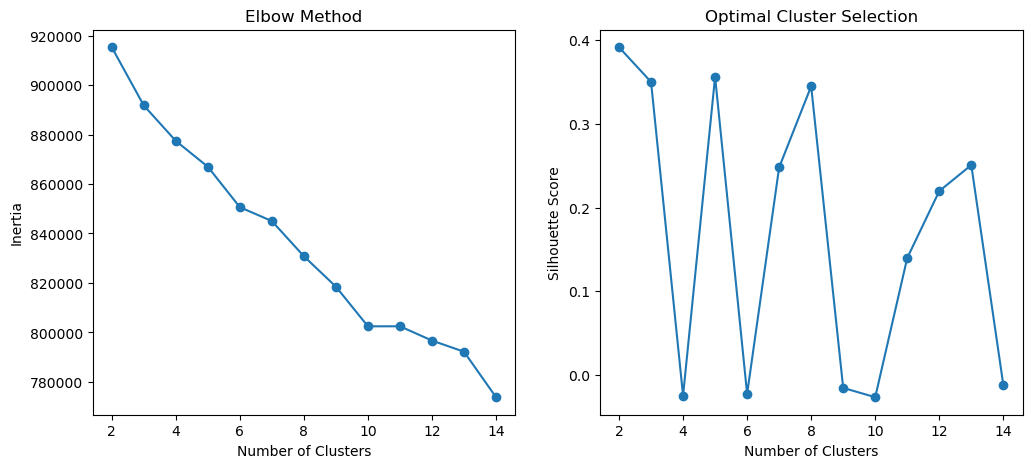

In [5]:
# Split data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Aggregate ratings by user-movie pairs
train_data = train_data.groupby(['userId', 'movieId']).agg({'rating': 'mean'}).reset_index()

# Create user-item matrix
user_item_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Determine optimal cluster count using Elbow Method and Silhouette Score
sil_scores = []
inertia_scores = []
cluster_range = range(2, 15)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(user_item_matrix)
    sil_scores.append(silhouette_score(user_item_matrix, clusters))
    inertia_scores.append(kmeans.inertia_)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, sil_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Cluster Selection')
plt.show()

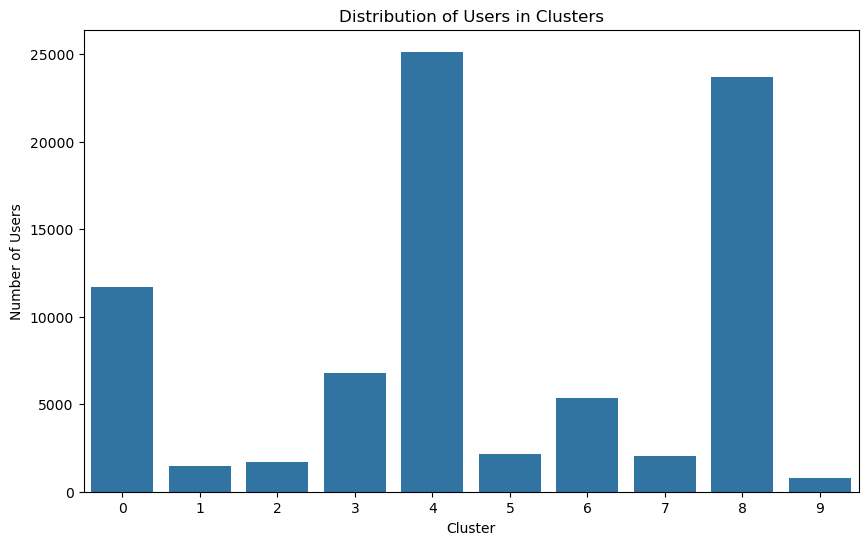

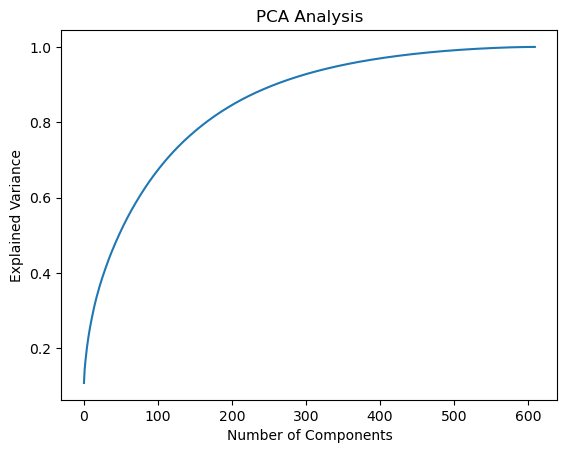

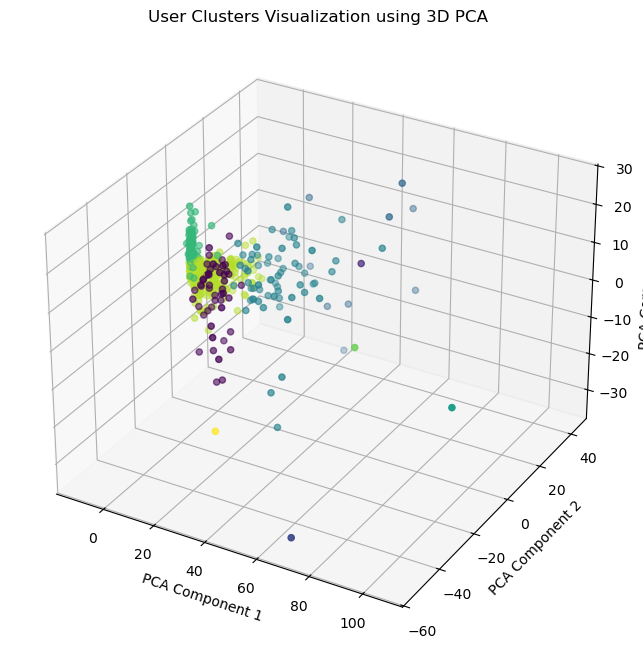

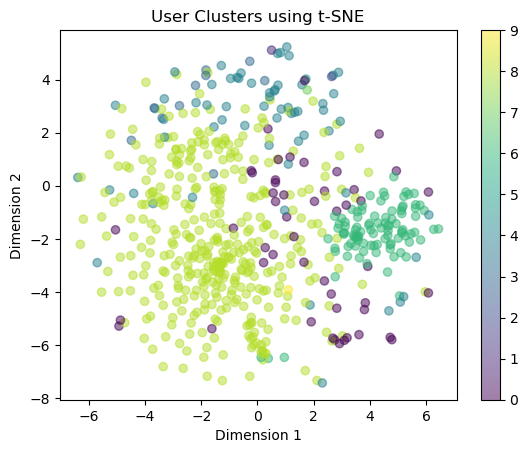

In [6]:
# Apply K-Means clustering with optimal clusters
optimal_k = 10  # Adjust based on Elbow Method/Silhouette Score
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
user_clusters = kmeans.fit_predict(user_item_matrix)
train_data['cluster'] = train_data['userId'].map(lambda x: user_clusters[x])

# Visualize cluster distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=train_data['cluster'])
plt.title('Distribution of Users in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.show()

# PCA Analysis for Variance Explanation
pca = PCA()
pca.fit(user_item_matrix)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Analysis')
plt.show()

# 3D PCA Visualization
pca = PCA(n_components=3)
user_item_matrix_pca = pca.fit_transform(user_item_matrix)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(user_item_matrix_pca[:, 0], user_item_matrix_pca[:, 1], user_item_matrix_pca[:, 2], c=user_clusters, cmap='viridis')
ax.set_title('User Clusters Visualization using 3D PCA')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

# t-SNE Visualization for Better Interpretation
tsne = TSNE(n_components=2, random_state=42)
user_item_matrix_tsne = tsne.fit_transform(user_item_matrix)
plt.scatter(user_item_matrix_tsne[:, 0], user_item_matrix_tsne[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('User Clusters using t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [9]:
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate


# Define the NCF model
def create_ncf_model(num_users, num_items, embedding_size=50):
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    item_embedding = Embedding(input_dim=num_items, output_dim=embedding_size, name='item_embedding')(item_input)
    
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    
    concat = Concatenate()([user_vecs, item_vecs])
    
    dense = Dense(128, activation='relu')(concat)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

# Get the number of unique users and items
num_users = df['userId'].nunique()
num_items = df['movieId'].nunique()

# Create the NCF model
ncf_model = create_ncf_model(num_users, num_items)

# Prepare training data for NCF
user_train = train_data['userId'].values
item_train = train_data['movieId'].values
rating_train = train_data['rating'].values

# Train the NCF model
history = ncf_model.fit([user_train, item_train], rating_train, epochs=10, batch_size=64, validation_split=0.2)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

ModuleNotFoundError: No module named 'tensorflow.keras'

In [ ]:
import numpy as np

def hybrid_recommendation(user_id, n_recommendations=10):
    # Get the top N items recommended by NCF
    user_input = np.array([user_id] * num_items)
    item_input = np.array(range(num_items))
    predictions = ncf_model.predict([user_input, item_input])
    
    top_n_items = np.argsort(predictions[:, 0])[-n_recommendations:]
    
    return top_n_items

# Example usage
user_id = 1
recommendations = hybrid_recommendation(user_id)
print("Recommended items for user {}: {}".format(user_id, recommendations))